In [1]:
# Day 1: Data Loading & Cleaning

import pandas as pd
import os

# Ensure data folder exists
os.makedirs("../data", exist_ok=True)

In [4]:
# File path (adjust if needed)
file_path = "../data/OnlineRetail.csv"

# Load dataset with proper encoding
df = pd.read_csv(file_path, encoding='unicode_escape')

# Initial look
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (541909, 10)


,ï»¿InvoiceNo,InvoiceDate,InvoiceTime,StockCode,Description,Quantity,UnitPrice,Totalsale,CustomerID,Country
0,536365,01-12-2010,08:26:00 AM,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850.0,United Kingdom
1,536365,01-12-2010,08:26:00 AM,71053,WHITE METAL LANTERN,6,3.39,20.34,17850.0,United Kingdom
2,536365,01-12-2010,08:26:00 AM,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850.0,United Kingdom
3,536365,01-12-2010,08:26:00 AM,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850.0,United Kingdom
4,536365,01-12-2010,08:26:00 AM,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850.0,United Kingdom


In [5]:
# Info about columns and data types
df.info()

# Missing values check
print("\nMissing Values:\n", df.isnull().sum())

# Basic statistics for numeric columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ï»¿InvoiceNo  541909 non-null  object 
 1   InvoiceDate   541909 non-null  object 
 2   InvoiceTime   541909 non-null  object 
 3   StockCode     541909 non-null  object 
 4   Description   540455 non-null  object 
 5   Quantity      541909 non-null  int64  
 6   UnitPrice     541909 non-null  float64
 7   Totalsale     541909 non-null  float64
 8   CustomerID    406829 non-null  float64
 9   Country       541909 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 41.3+ MB

Missing Values:
 ï»¿InvoiceNo         0
InvoiceDate          0
InvoiceTime          0
StockCode            0
Description       1454
Quantity             0
UnitPrice            0
Totalsale            0
CustomerID      135080
Country              0
dtype: int64


,Quantity,UnitPrice,Totalsale,CustomerID
count,541909.000000,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,17.987795,15287.690570
std,218.081158,96.759853,378.810824,1713.600303
min,-80995.000000,-11062.060000,-168469.600000,12346.000000
25%,1.000000,1.250000,3.400000,13953.000000
50%,3.000000,2.080000,9.750000,15152.000000
75%,10.000000,4.130000,17.400000,16791.000000
max,80995.000000,38970.000000,168469.600000,18287.000000


In [25]:
import pandas as pd

# 1. Load with encoding fix
file_path = "../data/OnlineRetail.csv"  # Adjust path if needed
df = pd.read_csv(file_path, encoding="utf-8-sig")

# 2. Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# 3. Check column names
print(df.columns.tolist())

# 4. Remove cancelled orders
df = df[~df['invoiceno'].astype(str).str.startswith('C')]

print("After removing cancellations:", df.shape)


['invoiceno', 'invoicedate', 'invoicetime', 'stockcode', 'description', 'quantity', 'unitprice', 'totalsale', 'customerid', 'country']
After removing cancellations: (532621, 10)


In [36]:
print(df.columns.tolist())


['invoiceno', 'invoicedate', 'invoicetime', 'stockcode', 'description', 'quantity', 'unitprice', 'totalsale', 'customerid', 'country']


In [40]:
# Ensure df is an independent copy
df = df.copy()

# Rename column and drop missing CustomerIDs
df.rename(columns={"customerid": "CustomerID"}, inplace=True)
df = df.dropna(subset=["CustomerID"])


In [44]:
df["InvoiceDateTime"] = pd.to_datetime(
    df["invoicedate"] + " " + df["invoicetime"], 
    dayfirst=True
)


In [45]:
df["TotalPrice"] = df["quantity"] * df["unitprice"]


In [55]:
print(df.columns.tolist())


['invoiceno', 'invoicedate', 'invoicetime', 'stockcode', 'description', 'quantity', 'unitprice', 'totalsale', 'customerid', 'country', 'InvoiceDateTime', 'TotalPrice']


In [58]:
# Drop rows with missing customer IDs
df = df.dropna(subset=["customerid"])

# Set reference date (one day after the latest purchase date)
reference_date = df["invoicedate"].max() + pd.Timedelta(days=1)

# Compute RFM
rfm = df.groupby("customerid").agg({
    "invoicedate": lambda x: (reference_date - x.max()).days,  # Recency
    "invoiceno": "nunique",                                   # Frequency
    "totalsale": "sum"                                        # Monetary
}).reset_index()

# Rename columns for clarity
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        3          7   4310.00
2     12348.0       76          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      311          1    334.40


In [59]:
# RFM Scoring
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])  # Lower Recency → Higher Score
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])  # Higher Frequency → Higher Score
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])  # Higher Monetary → Higher Score

# Combine into RFM_Segment
rfm["RFM_Segment"] = (
    rfm["R_Score"].astype(str) + 
    rfm["F_Score"].astype(str) + 
    rfm["M_Score"].astype(str)
)

# Calculate an overall RFM score
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(int) + 
    rfm["F_Score"].astype(int) + 
    rfm["M_Score"].astype(int)
)

print(rfm.head())


   CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0     12346.0      326          1  77183.60       1       1       5   
1     12347.0        3          7   4310.00       5       5       5   
2     12348.0       76          4   1797.24       2       4       4   
3     12349.0       19          1   1757.55       4       1       4   
4     12350.0      311          1    334.40       1       1       2   

  RFM_Segment  RFM_Score  
0         115          7  
1         555         15  
2         244         10  
3         414          9  
4         112          4  


In [60]:
# Define RFM categories
def rfm_category(row):
    if row['RFM_Score'] >= 13:
        return 'Champions'  # Recent, frequent, high spenders
    elif row['RFM_Score'] >= 10:
        return 'Loyal Customers'  # Frequent buyers, good spenders
    elif row['RFM_Score'] >= 7:
        return 'Potential Loyalists'  # New or infrequent but high spenders
    elif row['RFM_Score'] >= 5:
        return 'At Risk'  # Haven’t purchased recently
    else:
        return 'Lost Customers'  # Inactive and low value

# Apply function
rfm['Customer_Segment'] = rfm.apply(rfm_category, axis=1)

print(rfm.head())


   CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0     12346.0      326          1  77183.60       1       1       5   
1     12347.0        3          7   4310.00       5       5       5   
2     12348.0       76          4   1797.24       2       4       4   
3     12349.0       19          1   1757.55       4       1       4   
4     12350.0      311          1    334.40       1       1       2   

  RFM_Segment  RFM_Score     Customer_Segment  
0         115          7  Potential Loyalists  
1         555         15            Champions  
2         244         10      Loyal Customers  
3         414          9  Potential Loyalists  
4         112          4       Lost Customers  


In [61]:
segment_summary = rfm['Customer_Segment'].value_counts().reset_index()
segment_summary.columns = ['Customer_Segment', 'Count']
print(segment_summary)


      Customer_Segment  Count
0  Potential Loyalists   1090
1      Loyal Customers   1009
2            Champions    931
3              At Risk    765
4       Lost Customers    544


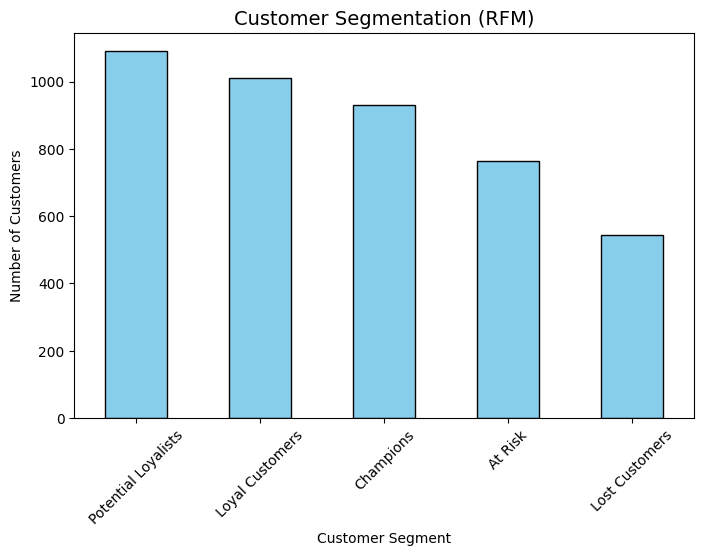

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
rfm['Customer_Segment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Customer Segmentation (RFM)', fontsize=14)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [63]:
rfm.to_csv("RFM_Customer_Segmentation.csv", index=False)
